In [317]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
%autoreload

In [319]:
import os
import pandas as pd
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [320]:
import scripts
print(scripts.__path__)
import pathlib

from scripts.common.schemas import TypeCollectionCategory
from scripts.infer.structure import DatasetFolderStructure

dataset = DatasetFolderStructure(pathlib.Path(
    "/nfs/home/bsparks/mdti4py/datasets/better-types-4-py-dataset"
))
assert dataset.dataset_root.is_dir(), f"{dataset.dataset_root} not a directory!"

print(dataset)

['/nfs/home/bsparks/mdti4py/scripts/scripts']
BetterTypes4Py @ /nfs/home/bsparks/mdti4py/datasets/better-types-4-py-dataset


In [321]:
import importlib
import experiments.inferred
import experiments.probas

In [322]:
artifact_root = pathlib.Path("/nfs/home/bsparks/mdti4py/datasets")
assert artifact_root.is_dir(), f"Cannot find {artifact_root=}"

In [323]:
importlib.reload(experiments.inferred)
groundtruth = experiments.inferred.load_groundtruths(artifact_root, dataset)

trivial_mask = groundtruth.base_anno.isin(["None", "Any"])
groundtruth = groundtruth[~trivial_mask]

display(groundtruth.shape, groundtruth.columns)
# display(groundtruth.head())

/nfs/home/bsparks/mdti4py/datasets/BetterTypes4Py/kornicameister__axion/extended_ground_truth.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.51it/s]
/nfs/home/bsparks/mdti4py/datasets/BetterTypes4Py/kornicameister__axion/context.csv: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 139.56it/s]


(51272, 9)

Index(['file', 'category', 'qname', 'qname_ssa', 'raw_anno',
       'depth_limited_anno', 'adjusted_anno', 'base_anno', 'repository'],
      dtype='object')

In [324]:
type4py = experiments.inferred.load_entire_inferred(artifact_root, dataset, tool_name="type4pyN1", task="all")
type4py_probas = experiments.probas.load_inferred_with_probablities(artifact_root, dataset, tool_name="type4py", task="all", inferred=type4py)

anno_no_prob = type4py_probas["probability"].isna() & type4py_probas["anno"].notna()
type4py_probas.loc[anno_no_prob, "anno"] = pd.NA

# print((type4py_probas["probability"].isna() & type4py_probas["anno"].notna()).any())#

/nfs/home/bsparks/mdti4py/datasets/BetterTypes4Py/kornicameister__axion/type4pyN1/all/inferred.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 131.94it/s]


Valid: 57682 / 58215
Annotated & Has Probability: 34608 / 35141
0 entries with a probability but no annotation
533 entries with an annotation but no probability
                                repository  \
4859               basilisp-lang__basilisp   
4860               basilisp-lang__basilisp   
4861               basilisp-lang__basilisp   
4862               basilisp-lang__basilisp   
4863               basilisp-lang__basilisp   
...                                    ...   
2888  marcosschroh__dataclasses-avroschema   
2891  marcosschroh__dataclasses-avroschema   
2892  marcosschroh__dataclasses-avroschema   
2900  marcosschroh__dataclasses-avroschema   
2901  marcosschroh__dataclasses-avroschema   

                                     file  category  \
4859  src/basilisp/lang/compiler/nodes.py  VARIABLE   
4860  src/basilisp/lang/compiler/nodes.py  VARIABLE   
4861  src/basilisp/lang/compiler/nodes.py  VARIABLE   
4862  src/basilisp/lang/compiler/nodes.py  VARIABLE   
4863  src/b

In [325]:
typilus = experiments.inferred.load_entire_inferred(artifact_root, dataset, tool_name="typilusN1", task="all")
typilus_probas = experiments.probas.load_inferred_with_probablities(artifact_root, dataset, tool_name="typilus", task="all", inferred=typilus)

anno_no_prob = typilus_probas["probability"].isna() & typilus_probas["anno"].notna()
typilus_probas.loc[anno_no_prob, "anno"] = pd.NA

#print((typilus_probas["probability"].isna() & typilus_probas["anno"].notna()).any())#

/nfs/home/bsparks/mdti4py/datasets/BetterTypes4Py/kornicameister__axion/typilusN1/all/inferred.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 132.11it/s]


Valid: 58112 / 58215
Annotated & Has Probability: 41493 / 41596
0 entries with a probability but no annotation
103 entries with an annotation but no probability
                             repository  \
415          ActivityWatch__aw-research   
416          ActivityWatch__aw-research   
979                AxelVoitier__lookups   
392               ClearcodeHQ__mirakuru   
394               ClearcodeHQ__mirakuru   
...                                 ...   
606       reddit__baseplate.py-upgrader   
785   scalableminds__webknossos-connect   
1511                   seattleflu__id3c   
243    typeddjango__pytest-mypy-plugins   
2523           webrecorder__browsertrix   

                                              file  category  \
415                            aw_research/plot.py  VARIABLE   
416                            aw_research/plot.py  VARIABLE   
979                   tests/test_generic_lookup.py  VARIABLE   
392                      tests/server_for_tests.py  VARIABLE   
39

In [326]:
typet5 = experiments.inferred.load_entire_inferred(artifact_root, dataset, tool_name="TypeT5TopN1", task="all")
typet5_probas = experiments.probas.load_inferred_with_probablities(artifact_root, dataset, tool_name="typet5", task="all", inferred=typet5)

/nfs/home/bsparks/mdti4py/datasets/BetterTypes4Py/kornicameister__axion/TypeT5TopN1/all/inferred.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 131.20it/s]


Valid: 58215 / 58215
Annotated & Has Probability: 23038 / 23038
0 entries with a probability but no annotation
0 entries with an annotation but no probability


In [327]:
ignore = ["topn"]
prediction_annos = ["anno_type4py", "anno_typilus", "anno_typet5"]
methods = ["method_type4py", "method_typilus", "method_typet5"]
probs = ["probability_type4py", "probability_typilus", "probability_typet5"]

In [328]:
type4py_adjusted = experiments.inferred.typet5_adjusted_form(type4py_probas)
typilus_adjusted = experiments.inferred.typet5_adjusted_form(typilus_probas)
typet5_adjusted = experiments.inferred.typet5_adjusted_form(typet5_probas)

aligned_adjusted = type4py_adjusted.drop(columns=ignore).merge(
    typilus_adjusted.drop(columns=ignore), 
    how="outer", 
    on=["repository", "category", "file", "qname", "qname_ssa"], 
    suffixes=("_type4py", "_typilus")
).merge(
    typet5_adjusted.drop(columns=ignore).rename(columns={"anno": "anno_typet5", "probability": "probability_typet5", "method": "method_typet5"}),
    how="outer", 
    on=["repository", "category", "file", "qname", "qname_ssa"]
)

aligned_adjusted.info()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58215/58215 [00:00<00:00, 186834.80it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58215 entries, 0 to 58214
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file                 58215 non-null  object
 1   category             58215 non-null  object
 2   qname                58215 non-null  object
 3   qname_ssa            58215 non-null  object
 4   anno_type4py         34553 non-null  object
 5   method_type4py       58161 non-null  object
 6   repository           58215 non-null  object
 7   probability_type4py  34554 non-null  object
 8   anno_typilus         41344 non-null  object
 9   method_typilus       58066 non-null  object
 10  probability_typilus  41344 non-null  object
 11  anno_typet5          17342 non-null  object
 12  method_typet5        52519 non-null  object
 13  probability_typet5   17342 non-null  object
dtypes: object(14)
memory usage: 6.2+ MB


In [329]:
type4py_base = experiments.inferred.typet5_base_form(type4py_probas)
typilus_base = experiments.inferred.typet5_base_form(typilus_probas)
typet5_base = experiments.inferred.typet5_base_form(typet5_probas)

aligned_base = type4py_base.drop(columns=ignore).merge(
    typilus_base.drop(columns=ignore), 
    how="outer", 
    on=["repository", "category", "file", "qname", "qname_ssa"], 
    suffixes=("_type4py", "_typilus")
).merge(
    typet5_base.drop(columns=ignore).rename(columns={"anno": "anno_typet5", "probability": "probability_typet5", "method": "method_typet5"}),
    how="outer", 
    on=["repository", "category", "file", "qname", "qname_ssa"]
)

aligned_base.info()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58215/58215 [00:00<00:00, 194965.13it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58215 entries, 0 to 58214
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file                 58215 non-null  object
 1   category             58215 non-null  object
 2   qname                58215 non-null  object
 3   qname_ssa            58215 non-null  object
 4   anno_type4py         34553 non-null  object
 5   method_type4py       58161 non-null  object
 6   repository           58215 non-null  object
 7   probability_type4py  34554 non-null  object
 8   anno_typilus         41344 non-null  object
 9   method_typilus       58066 non-null  object
 10  probability_typilus  41344 non-null  object
 11  anno_typet5          17342 non-null  object
 12  method_typet5        52519 non-null  object
 13  probability_typet5   17342 non-null  object
dtypes: object(14)
memory usage: 6.2+ MB


In [330]:
from scripts.common.schemas import ExtendedTypeCollectionSchema

In [331]:
importlib.reload(experiments.inferred)
joined_adjusted = experiments.inferred.join_truth_to_preds(
    truth=groundtruth,
    predictions=aligned_adjusted,
    comparable_anno=ExtendedTypeCollectionSchema.adjusted_anno,
    prediction_annos=prediction_annos,
)

adjusted_eval = experiments.inferred.evaluatable(joined_adjusted, clean_annos=prediction_annos).replace("<MISSING>", pd.NA)

print(adjusted_eval.info())
adjusted_eval

<class 'pandas.core.frame.DataFrame'>
Index: 15752 entries, 5 to 51271
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file                 15752 non-null  object
 1   category             15752 non-null  object
 2   qname                15752 non-null  object
 3   qname_ssa            15752 non-null  object
 4   gt_anno              15752 non-null  object
 5   repository           15752 non-null  object
 6   trait_gt_form        15752 non-null  object
 7   anno_type4py         13957 non-null  object
 8   method_type4py       15730 non-null  object
 9   probability_type4py  13957 non-null  object
 10  anno_typilus         15025 non-null  object
 11  method_typilus       15709 non-null  object
 12  probability_typilus  15025 non-null  object
 13  anno_typet5          10477 non-null  object
 14  method_typet5        15547 non-null  object
 15  probability_typet5   10477 non-null  object
dtypes: object

/nfs/home/bsparks/mdti4py/scripts/experiments/inferred.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # remove None, Any


,file,category,qname,qname_ssa,gt_anno,repository,trait_gt_form,anno_type4py,method_type4py,probability_type4py,anno_typilus,method_typilus,probability_typilus,anno_typet5,method_typet5,probability_typet5
5,tests/application/domain/common/tenancy/test_t...,CALLABLE_RETURN,tenant,tenant,Tenant,nubark__instark,Tenant,str,type4pyN1,0.394473,str,typilusN1,1.0,Tenant,TypeT5TopN1,0.999991
6,tests/application/domain/common/tenancy/test_t...,CALLABLE_PARAMETER,test_tenant_creation.tenant,test_tenant_creation.tenant,Tenant,nubark__instark,Tenant,Tenant,type4pyN1,1.0,str,typilusN1,1.0,Tenant,TypeT5TopN1,0.997448
7,tests/application/domain/common/tenancy/test_t...,CALLABLE_PARAMETER,test_tenant_default_attributes.tenant,test_tenant_default_attributes.tenant,Tenant,nubark__instark,Tenant,Tenant,type4pyN1,1.0,Path,typilusN1,0.45823,Tenant,TypeT5TopN1,0.999992
16,instark/core/suppliers/common/connection/schem...,CALLABLE_PARAMETER,SchemaConnection.__init__.dsn,SchemaConnection.__init__.dsn,str,nubark__instark,str,str,type4pyN1,0.668681,str,typilusN1,0.861019,str,TypeT5TopN1,0.999994
19,instark/core/suppliers/common/connection/schem...,CALLABLE_RETURN,SchemaConnection.execute,SchemaConnection.execute,str,nubark__instark,str,Set[str],type4pyN1,0.652295,str,typilusN1,1.0,str,TypeT5TopN1,0.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51267,examples/petstore/api/__init__.py,CALLABLE_PARAMETER,find_pet.id,find_pet.id,int,kornicameister__axion,int,int,type4pyN1,0.999997,str,typilusN1,0.721523,str,TypeT5TopN1,0.986359
51268,examples/petstore/api/__init__.py,CALLABLE_RETURN,delete_pet,delete_pet,Response,kornicameister__axion,Response,int,type4pyN1,0.504948,Dict,typilusN1,0.215235,"Dict[str, int]",TypeT5TopN1,0.984306
51269,examples/petstore/api/__init__.py,CALLABLE_PARAMETER,delete_pet.id,delete_pet.id,int,kornicameister__axion,int,int,type4pyN1,0.999995,str,typilusN1,0.640083,str,TypeT5TopN1,0.984306
51270,examples/petstore/api/__init__.py,CALLABLE_RETURN,new_pet,new_pet,Response,kornicameister__axion,Response,str,type4pyN1,0.496209,Tuple,typilusN1,0.236058,"Dict[str, Any]",TypeT5TopN1,0.982894


In [332]:
joined_base = experiments.inferred.join_truth_to_preds(
    truth=groundtruth,
    predictions=aligned_base,
    comparable_anno=ExtendedTypeCollectionSchema.base_anno,
    prediction_annos=["anno_type4py", "anno_typilus", "anno_typet5"]
)
joined_base 

base_eval = experiments.inferred.evaluatable(joined_base, clean_annos=prediction_annos).replace("<MISSING>", pd.NA)

print(base_eval.info())
display(base_eval)

/nfs/home/bsparks/mdti4py/scripts/experiments/inferred.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # remove None, Any


<class 'pandas.core.frame.DataFrame'>
Index: 15752 entries, 5 to 51271
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file                 15752 non-null  object
 1   category             15752 non-null  object
 2   qname                15752 non-null  object
 3   qname_ssa            15752 non-null  object
 4   gt_anno              15752 non-null  object
 5   repository           15752 non-null  object
 6   trait_gt_form        15752 non-null  object
 7   anno_type4py         13957 non-null  object
 8   method_type4py       15730 non-null  object
 9   probability_type4py  13957 non-null  object
 10  anno_typilus         15025 non-null  object
 11  method_typilus       15709 non-null  object
 12  probability_typilus  15025 non-null  object
 13  anno_typet5          10477 non-null  object
 14  method_typet5        15547 non-null  object
 15  probability_typet5   10477 non-null  object
dtypes: object

,file,category,qname,qname_ssa,gt_anno,repository,trait_gt_form,anno_type4py,method_type4py,probability_type4py,anno_typilus,method_typilus,probability_typilus,anno_typet5,method_typet5,probability_typet5
5,tests/application/domain/common/tenancy/test_t...,CALLABLE_RETURN,tenant,tenant,Tenant,nubark__instark,Tenant,str,type4pyN1,0.394473,str,typilusN1,1.0,Tenant,TypeT5TopN1,0.999991
6,tests/application/domain/common/tenancy/test_t...,CALLABLE_PARAMETER,test_tenant_creation.tenant,test_tenant_creation.tenant,Tenant,nubark__instark,Tenant,Tenant,type4pyN1,1.0,str,typilusN1,1.0,Tenant,TypeT5TopN1,0.997448
7,tests/application/domain/common/tenancy/test_t...,CALLABLE_PARAMETER,test_tenant_default_attributes.tenant,test_tenant_default_attributes.tenant,Tenant,nubark__instark,Tenant,Tenant,type4pyN1,1.0,Path,typilusN1,0.45823,Tenant,TypeT5TopN1,0.999992
16,instark/core/suppliers/common/connection/schem...,CALLABLE_PARAMETER,SchemaConnection.__init__.dsn,SchemaConnection.__init__.dsn,str,nubark__instark,str,str,type4pyN1,0.668681,str,typilusN1,0.861019,str,TypeT5TopN1,0.999994
19,instark/core/suppliers/common/connection/schem...,CALLABLE_RETURN,SchemaConnection.execute,SchemaConnection.execute,str,nubark__instark,str,Set,type4pyN1,0.652295,str,typilusN1,1.0,str,TypeT5TopN1,0.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51267,examples/petstore/api/__init__.py,CALLABLE_PARAMETER,find_pet.id,find_pet.id,int,kornicameister__axion,int,int,type4pyN1,0.999997,str,typilusN1,0.721523,str,TypeT5TopN1,0.986359
51268,examples/petstore/api/__init__.py,CALLABLE_RETURN,delete_pet,delete_pet,Response,kornicameister__axion,Response,int,type4pyN1,0.504948,Dict,typilusN1,0.215235,Dict,TypeT5TopN1,0.984306
51269,examples/petstore/api/__init__.py,CALLABLE_PARAMETER,delete_pet.id,delete_pet.id,int,kornicameister__axion,int,int,type4pyN1,0.999995,str,typilusN1,0.640083,str,TypeT5TopN1,0.984306
51270,examples/petstore/api/__init__.py,CALLABLE_RETURN,new_pet,new_pet,Response,kornicameister__axion,Response,str,type4pyN1,0.496209,Tuple,typilusN1,0.236058,Dict,TypeT5TopN1,0.982894


# Aggregation

In [333]:
display(adjusted_predictions := adjusted_eval[prediction_annos])
display(adjusted_probabilities := adjusted_eval[probs])

,anno_type4py,anno_typilus,anno_typet5
5,str,str,Tenant
6,Tenant,str,Tenant
7,Tenant,Path,Tenant
16,str,str,str
19,Set[str],str,str
...,...,...,...
51267,int,str,str
51268,int,Dict,"Dict[str, int]"
51269,int,str,str
51270,str,Tuple,"Dict[str, Any]"


,probability_type4py,probability_typilus,probability_typet5
5,0.394473,1.0,0.999991
6,1.0,1.0,0.997448
7,1.0,0.45823,0.999992
16,0.668681,0.861019,0.999994
19,0.652295,1.0,0.999995
...,...,...,...
51267,0.999997,0.721523,0.986359
51268,0.504948,0.215235,0.984306
51269,0.999995,0.640083,0.984306
51270,0.496209,0.236058,0.982894


In [334]:
import experiments.predictions

#print("Adjusted")
typilus_adjusted_accuracy = experiments.predictions.performance(
    adjusted_eval.rename(columns={"anno_typilus": "anno"}),
    total=True
)
type4py_adjusted_accuracy = experiments.predictions.performance(
    adjusted_eval.rename(columns={"anno_type4py": "anno"}),
    total=True
)
typet5_adjusted_accuracy = experiments.predictions.performance(
    adjusted_eval.rename(columns={"anno_typet5": "anno"}),
    total=True
)

#print("Base")
typilus_base_accuracy = experiments.predictions.performance(
    base_eval.rename(columns={"anno_typilus": "anno"}),
    total=True
)
type4py_base_accuracy = experiments.predictions.performance(
    base_eval.rename(columns={"anno_type4py": "anno"}),
    total=True
)
typet5_base_accuracy = experiments.predictions.performance(
    base_eval.rename(columns={"anno_typet5": "anno"}),
    total=True
)

Series([], Name: trait_gt_form, dtype: bool)
Series([], Name: trait_gt_form, dtype: bool)
Series([], Name: trait_gt_form, dtype: bool)
Series([], Name: trait_gt_form, dtype: bool)
Series([], Name: trait_gt_form, dtype: bool)
Series([], Name: trait_gt_form, dtype: bool)


In [335]:
common = ["observations"]
model_specific = ["predictions", "accuracy"]
ground_truth_columns = typilus_adjusted_accuracy[common] 

In [336]:
display(adjusted_baseline := pd.concat(
    [ground_truth_columns, typilus_adjusted_accuracy[model_specific], type4py_adjusted_accuracy[model_specific], typet5_adjusted_accuracy[model_specific]],
    keys=["groundtruth", "typilus", "type4py", "typet5"],
    axis=1
))
#|l|c|cc|cc|cc|
print(adjusted_baseline.to_latex(
    column_format="|l|c|cc|cc|cc|",
    float_format="%.2f",
    label="tbl:adjusted_ml_perf",
    caption=("Performance of ML models upon adjusted canonical form")
))

groundtruth     typilus               type4py                typet5  \
       observations predictions  accuracy predictions  accuracy predictions   
common         5651        5460  0.064413        5021  0.278889        3548   
rare           3235        3063  0.039876        2773  0.090263        2085   
ubiq           6866        6502  0.642004        6163  0.629624        4844   
total         15752       15025  0.311135       13957  0.393029       10477   

                  
        accuracy  
common  0.290745  
rare    0.458114  
ubiq    0.624964  
total   0.470797

\begin{table}
\caption{Performance of ML models upon adjusted canonical form}
\label{tbl:adjusted_ml_perf}
\begin{tabular}{|l|c|cc|cc|cc|}
\toprule
 & groundtruth & \multicolumn{2}{r}{typilus} & \multicolumn{2}{r}{type4py} & \multicolumn{2}{r}{typet5} \\
 & observations & predictions & accuracy & predictions & accuracy & predictions & accuracy \\
\midrule
common & 5651 & 5460 & 0.06 & 5021 & 0.28 & 3548 & 0.29 \\
rare & 3235 & 3063 & 0.04 & 2773 & 0.09 & 2085 & 0.46 \\
ubiq & 6866 & 6502 & 0.64 & 6163 & 0.63 & 4844 & 0.62 \\
total & 15752 & 15025 & 0.31 & 13957 & 0.39 & 10477 & 0.47 \\
\bottomrule
\end{tabular}
\end{table}



In [337]:
display(base_baseline := pd.concat(
    [ground_truth_columns, typilus_base_accuracy[model_specific], type4py_base_accuracy[model_specific], typet5_base_accuracy[model_specific]],
    keys=["groundtruth", "typilus", "type4py", "typet5"],
    axis=1
))

print(adjusted_baseline.to_latex(
    label="tbl:base_ml_perf",
    caption=("Performance of ML models upon base canonical form")
))

groundtruth     typilus               type4py                typet5  \
       observations predictions  accuracy predictions  accuracy predictions   
common         5651        5460  0.137321        5021  0.322244        3548   
rare           3235        3063  0.040495        2773  0.092117        2085   
ubiq           6866        6502  0.695747        6163  0.657734        4844   
total         15752       15025  0.360843       13957  0.421216       10477   

                  
        accuracy  
common  0.389843  
rare    0.472334  
ubiq    0.650015  
total   0.520188

\begin{table}
\caption{Performance of ML models upon base canonical form}
\label{tbl:base_ml_perf}
\begin{tabular}{lrrrrrrr}
\toprule
 & groundtruth & \multicolumn{2}{r}{typilus} & \multicolumn{2}{r}{type4py} & \multicolumn{2}{r}{typet5} \\
 & observations & predictions & accuracy & predictions & accuracy & predictions & accuracy \\
\midrule
common & 5651 & 5460 & 0.064413 & 5021 & 0.278889 & 3548 & 0.290745 \\
rare & 3235 & 3063 & 0.039876 & 2773 & 0.090263 & 2085 & 0.458114 \\
ubiq & 6866 & 6502 & 0.642004 & 6163 & 0.629624 & 4844 & 0.624964 \\
total & 15752 & 15025 & 0.311135 & 13957 & 0.393029 & 10477 & 0.470797 \\
\bottomrule
\end{tabular}
\end{table}



In [338]:
display(baseline_base := pd.concat(
    [typilus_base_accuracy, type4py_base_accuracy, typet5_base_accuracy],
    keys=["typilus", "type4py", "typet5"],
    axis=1
))

typilus                                               type4py  \
       observations predictions unassigned matches  accuracy observations   
common         5651        5460        191     776  0.137321         5651   
rare           3235        3063        172     131  0.040495         3235   
ubiq           6866        6502        364    4777  0.695747         6866   
total         15752       15025        727    5684  0.360843        15752   

                                                      typet5              \
       predictions unassigned matches  accuracy observations predictions   
common        5021        630    1821  0.322244         5651        3548   
rare          2773        462     298  0.092117         3235        2085   
ubiq          6163        703    4516  0.657734         6866        4844   
total        13957       1795    6635  0.421216        15752       10477   

                                     
       unassigned matches  accuracy  
common       2103    2203  0.389843  
rare         1150    1528  0.472334  
ubiq         2022    4463  0.650015  
total        5275    8194  0.520188

# Baseline majority vote

In [339]:
!pip install scikit-learn

In [340]:
import experiments.predictions
import pandas as pd

def hard_majority(df: pd.DataFrame) -> pd.DataFrame:
    predictions = df[prediction_annos]
    
    hm = predictions.mode(axis="columns")[0]
    # assert not hm.isna().any(), f"NAs: {hm.isna().sum()}"
    return experiments.predictions.performance(pd.merge(
        left=df, 
        right=hm.rename("anno"), 
        left_index=True, 
        right_index=True
    ), total=True)

display(adjusted_hard_majority := hard_majority(adjusted_eval))
display(base_hard_majority := hard_majority(base_eval))

Series([], Name: trait_gt_form, dtype: bool)


,observations,predictions,unassigned,matches,accuracy
common,5651,5562,89,1469,0.259954
rare,3235,3143,92,791,0.244513
ubiq,6866,6743,123,5198,0.757064
total,15752,15448,304,7458,0.473464


Series([], Name: trait_gt_form, dtype: bool)


,observations,predictions,unassigned,matches,accuracy
common,5651,5562,89,2109,0.373208
rare,3235,3143,92,813,0.251314
ubiq,6866,6743,123,5577,0.812263
total,15752,15448,304,8499,0.539551


In [341]:
import collections

def soft_majority_vote(df: pd.DataFrame) -> pd.DataFrame:
    def soft_majority(row) -> str:
        weighted_votes = collections.defaultdict(float)
        for pred_col, prob_col in zip(prediction_annos, probs):
            # print(pred_col, type(row[pred_col]), prob_col, type(row[prob_col]))
            weighted_votes[row[pred_col]] += row[prob_col]
        
        return max(weighted_votes, key=weighted_votes.get)

    df[probs] = df[probs].fillna(0)
    sm = df.apply(soft_majority, axis=1)
    # assert not sm.isna().any(), f"NAs: {sm.isna().sum()}"
    return experiments.predictions.performance(pd.merge(
        left=df, 
        right=sm.rename("anno"), 
        left_index=True, 
        right_index=True
    ), total=True)

display(adjusted_soft_majority := soft_majority_vote(adjusted_eval))
display(base_soft_majority := soft_majority_vote(base_eval))

Series([], Name: trait_gt_form, dtype: bool)


,observations,predictions,unassigned,matches,accuracy
common,5651,5562,89,2134,0.377632
rare,3235,3143,92,1384,0.427821
ubiq,6866,6743,123,5661,0.824498
total,15752,15448,304,9179,0.582720


Series([], Name: trait_gt_form, dtype: bool)


,observations,predictions,unassigned,matches,accuracy
common,5651,5562,89,2768,0.489825
rare,3235,3143,92,1433,0.442968
ubiq,6866,6743,123,5976,0.870376
total,15752,15448,304,10177,0.646077


In [342]:
identical_cols = ["predictions", "observations", "unassigned"]

In [343]:
pred_occ = adjusted_hard_majority[["predictions", "observations"]]

disp_adj_hm = adjusted_hard_majority.drop(columns=identical_cols)
disp_adj_sm = adjusted_soft_majority.drop(columns=identical_cols)

display(disp_adj_voting := pd.concat(
    [pred_occ, disp_adj_hm, disp_adj_sm],
    keys=["Statistics", "Hard Majority", "Soft Majority"],
    axis=1
))

print(disp_adj_voting.to_latex(
    float_format="%.2f",
    #label="tbl:adjusted_ml_perf",
    caption=("Performance of Voting Procedures upon adjusted canonical form")
))


Statistics              Hard Majority           Soft Majority  \
       predictions observations       matches  accuracy       matches   
common        5562         5651          1469  0.259954          2134   
rare          3143         3235           791  0.244513          1384   
ubiq          6743         6866          5198  0.757064          5661   
total        15448        15752          7458  0.473464          9179   

                  
        accuracy  
common  0.377632  
rare    0.427821  
ubiq    0.824498  
total   0.582720

\begin{table}
\caption{Performance of Voting Procedures upon adjusted canonical form}
\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{2}{r}{Statistics} & \multicolumn{2}{r}{Hard Majority} & \multicolumn{2}{r}{Soft Majority} \\
 & predictions & observations & matches & accuracy & matches & accuracy \\
\midrule
common & 5562 & 5651 & 1469 & 0.26 & 2134 & 0.38 \\
rare & 3143 & 3235 & 791 & 0.24 & 1384 & 0.43 \\
ubiq & 6743 & 6866 & 5198 & 0.76 & 5661 & 0.82 \\
total & 15448 & 15752 & 7458 & 0.47 & 9179 & 0.58 \\
\bottomrule
\end{tabular}
\end{table}



In [344]:
pred_occ = base_hard_majority[["predictions", "observations"]]

disp_base_hm = base_hard_majority.drop(columns=identical_cols)
disp_base_sm = base_soft_majority.drop(columns=identical_cols)

display(disp_base_voting := pd.concat(
    [pred_occ, disp_base_hm, disp_base_sm],
    keys=["Statistics", "Hard Majority", "Soft Majority"],
    axis=1
))

print(disp_base_voting.to_latex())

Statistics              Hard Majority           Soft Majority  \
       predictions observations       matches  accuracy       matches   
common        5562         5651          2109  0.373208          2768   
rare          3143         3235           813  0.251314          1433   
ubiq          6743         6866          5577  0.812263          5976   
total        15448        15752          8499  0.539551         10177   

                  
        accuracy  
common  0.489825  
rare    0.442968  
ubiq    0.870376  
total   0.646077

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{2}{r}{Statistics} & \multicolumn{2}{r}{Hard Majority} & \multicolumn{2}{r}{Soft Majority} \\
 & predictions & observations & matches & accuracy & matches & accuracy \\
\midrule
common & 5562 & 5651 & 2109 & 0.373208 & 2768 & 0.489825 \\
rare & 3143 & 3235 & 813 & 0.251314 & 1433 & 0.442968 \\
ubiq & 6743 & 6866 & 5577 & 0.812263 & 5976 & 0.870376 \\
total & 15448 & 15752 & 8499 & 0.539551 & 10177 & 0.646077 \\
\bottomrule
\end{tabular}



In [345]:
display(disp_voting := pd.concat(
    [
        pd.concat([pred_occ], keys=["Statistics"], axis=1),
        pd.concat([disp_adj_hm.drop(columns="matches"), disp_base_hm.drop(columns="matches")], keys=["adjusted", "base"], axis=1),
        pd.concat([disp_adj_sm.drop(columns="matches"), disp_base_sm.drop(columns="matches")], keys=["adjusted", "base"], axis=1),
    ],
    keys=["", "Hard Majority", "Soft Majority"], 
    axis=1
))

print(disp_voting.to_latex(
    float_format="%.2f",
    label="tbl:voting_ml_perf",
    caption=("Performance of Voting Procedures upon adjusted \& base canonical forms")
))

Hard Majority           Soft Majority  \
        Statistics                   adjusted      base      adjusted   
       predictions observations      accuracy  accuracy      accuracy   
common        5562         5651      0.259954  0.373208      0.377632   
rare          3143         3235      0.244513  0.251314      0.427821   
ubiq          6743         6866      0.757064  0.812263      0.824498   
total        15448        15752      0.473464  0.539551      0.582720   

                  
            base  
        accuracy  
common  0.489825  
rare    0.442968  
ubiq    0.870376  
total   0.646077

\begin{table}
\caption{Performance of Voting Procedures upon adjusted \& base canonical forms}
\label{tbl:voting_ml_perf}
\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{2}{r}{} & \multicolumn{2}{r}{Hard Majority} & \multicolumn{2}{r}{Soft Majority} \\
 & \multicolumn{2}{r}{Statistics} & adjusted & base & adjusted & base \\
 & predictions & observations & accuracy & accuracy & accuracy & accuracy \\
\midrule
common & 5562 & 5651 & 0.26 & 0.37 & 0.38 & 0.49 \\
rare & 3143 & 3235 & 0.24 & 0.25 & 0.43 & 0.44 \\
ubiq & 6743 & 6866 & 0.76 & 0.81 & 0.82 & 0.87 \\
total & 15448 & 15752 & 0.47 & 0.54 & 0.58 & 0.65 \\
\bottomrule
\end{tabular}
\end{table}



# Ensemble Learning

# Basheer

In [346]:
import abc, dataclasses, enum

@dataclasses.dataclass(frozen=True)
class BaheerMetadata:
    repository: str
    file: str
    category: TypeCollectionCategory
    qname_ssa: str


@dataclasses.dataclass(frozen=True)
class BaheerOpinion:
    prediction: str
    probability: float


@dataclasses.dataclass(frozen=True)
class BaheerResult:
    strategy: str
    agent_tag: str
    metadata: BaheerMetadata
    opinion: BaheerOpinion


class Confidence(enum.IntEnum):
    High = enum.auto()
    Low = enum.auto()

    @staticmethod
    def make(prob: float, threshold: float) -> "Confidence":
        if prob >= threshold:
            return Confidence.High
        else:
            return Confidence.Low

class Strategy(abc.ABC):
    def __init__(self, agent1_tag: str, agent2_tag: str) -> None:
        self.agent1_tag = agent1_tag
        self.agent2_tag = agent2_tag
    
    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        ...


class BaheerResolver(abc.ABC):
    def __init__(self, agent1_tag: str, agent1_threshold: float, agent2_tag: str, agent2_threshold: float) -> None:
        self.agent1_tag = agent1_tag
        self.agent2_tag = agent2_tag

        self.agent1_threshold = agent1_threshold
        self.agent2_threshold = agent2_threshold
    
    @abc.abstractmethod
    def resolve(self, agent1_pred: str, agent1_prob: float, agent2_pred: str, agent2_prob: float) -> BaheerResult:
        ...

In [347]:
class Submitting(Strategy):
    """Agent 1 submits to Agent 2"""
    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        return BaheerResult(strategy="submit", agent_tag=self.agent2_tag, metadata=metadata, opinion=agent2)

class Forcing(Strategy):
    """Agent 1 imposes its will over that of Agent 2"""
    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        return BaheerResult(strategy="force", agent_tag=self.agent1_tag, metadata=metadata, opinion=agent1)

class Delegation(Strategy):
    def __init__(self, agent1_tag: str, agent2_tag: str, agent3_tag: str, agent3_opinions: dict[BaheerMetadata, BaheerOpinion]) -> None:
        super().__init__(agent1_tag, agent2_tag)
        self.agent3_tag = agent3_tag
        self.agent3_opinions = agent3_opinions

    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        knowledge = self.agent3_opinions.get(metadata, (pd.NA, float("-inf")))
        return BaheerResult(strategy="delegate", agent_tag=self.agent3_tag, *knowledge)
    

class Ignoring(Strategy):
    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        return BaheerResult(strategy="ignore", agent_tag="IGNORED", metadata=metadata, opinion=BaheerOpinion(prediction=pd.NA, probability=float("-inf")))

class Negotiation(Strategy):
    def apply(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        if agent1.probability > agent2.probability:
            return BaheerResult(strategy="negotiate", agent_tag=self.agent1_tag, metadata=metadata, opinion=agent1)
        else:
            return BaheerResult(strategy="negotiate", agent_tag=self.agent2_tag, metadata=metadata, opinion=agent2)

In [348]:
class BaheerStrongConflictResolver(BaheerResolver):
    def __init__(self, agent1_tag: str, agent1_threshold: float, str, agent2_tag: str, agent2_threshold: float, agent3_opinions: dict[BaheerMetadata, BaheerOpinion]) -> None:
        super().__init__(agent1_tag, agent1_threshold, agent2_tag, agent2_threshold)
        self.agent3_opinions = agent3_opinions

    def resolve(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion, agent3: pd.DataFrame) -> BaheerResult:
        match Confidence.make(agent1.probability, self.agent1_threshold), Confidence.make(agent2.probability, self.agent2_threshold):
            case (Confidence.High, Confidence.High) | (Confidence.Low, Confidence.Low):
                return Delegation(self.agent1_tag, self.agent2_tag, self.agent3_opinions).apply(metadata, agent1, agent2)

            case (Confidence.High, Confidence.Low):
                return Forcing(self.agent1_tag, self.agent2_tag).apply(metadata, agent1, agent2)
        
            case (Confidence.Low, Confidence.High):
                return Forcing(self.agent2_tag, self.agent1_tag).apply(metadata, agent2, agent1)
        

In [349]:
class BaheerWeakConflictResolver(BaheerResolver):
    def resolve(self, metadata: BaheerMetadata, agent1: BaheerOpinion, agent2: BaheerOpinion) -> BaheerResult:
        match Confidence.make(agent1.probability, self.agent1_threshold), Confidence.make(agent2.probability, self.agent2_threshold):
            case (Confidence.Low, Confidence.Low):
                return Ignoring(self.agent1_tag, self.agent2_tag).apply(metadata, agent1, agent2)

            case (Confidence.High, Confidence.High):
                return Negotiation(self.agent1_tag, self.agent2_tag).apply(metadata, agent1, agent2)

            case (Confidence.High, Confidence.Low):
                return Submitting(self.agent1_tag, self.agent2_tag).apply(metadata, agent1, agent2)

            case (Confidence.Low, Confidence.High):
                return Submitting(self.agent2_tag, self.agent1_tag).apply(metadata, agent2, agent1)

In [350]:
def baheer(
    agent1: pd.DataFrame, agent1_tag: str, agent1_threshold: float,
    agent2: pd.DataFrame, agent2_tag: str, agent2_threshold: float,
    agent3: pd.DataFrame, agent3_tag: str
) -> pd.DataFrame:
    assert agent1.shape[0] == agent2.shape[0] == agent3.shape[0]
    # conflict_level = (agent1.pred.fillna("<MISSING>") == agent2.pred.fillna("<MISSING>")).sum() / len(agent1.pred)
    conflict_level = (agent1.pred == agent2.pred).sum() / len(agent1.pred)

    print(conflict_level)

    for agent in (agent1, agent2):
        agent.pred = agent.pred.fillna("<MISSING>")
        agent.probability = agent.probability.fillna(0.0)
            
    if conflict_level >= 0.5:
        negotiator: dict[BaheerMetadata, BaheerOpinion] = {
            BaheerMetadata(repository, file, cat, qname_ssa): BaheerOpinion(pred, prob)
            for file, cat, qname_ssa, pred, prob in agent3[["repository", "file", "category", "qname_ssa", "pred", "probability"]].itertuples(index=False)
            if pd.notna(pred)
        }
        resolver = BaheerStrongConflictResolver(agent1_tag, agent1_threshold, agent2_tag, agent2_threshold, agent3_tag, negotiator)
    else:
        resolver = BaheerWeakConflictResolver(agent1_tag, agent1_threshold, agent2_tag, agent2_threshold)

    method = type(resolver).__qualname__

    aligned = pd.merge(
        left=agent1,
        right=agent2,
        on=["repository", "file", "category", "qname", "qname_ssa"],
        how="outer",
        suffixes=("_agent1", "_agent2")
    )
    
    resolutions = []

    for row in aligned[["repository", "file", "category", "qname", "qname_ssa", "pred_agent1", "probability_agent1", "pred_agent2", "probability_agent2"]].itertuples(index=False):
        # print(len(row), row)
        repository, file, cat, qname, qname_ssa, agent1_pred, agent1_prob, agent2_pred, agent2_prob = row
        metadata = BaheerMetadata(repository, file, cat, qname_ssa)
        agent1_opinion = BaheerOpinion(agent1_pred, agent1_prob)
        agent2_opinion = BaheerOpinion(agent2_pred, agent2_prob)
    
        resolution = resolver.resolve(metadata, agent1_opinion, agent2_opinion)
        resolutions.append((
            resolution.metadata.repository, resolution.metadata.file, resolution.metadata.category, 
            qname, qname_ssa,
            resolution.agent_tag, resolution.opinion.prediction, resolution.opinion.probability, resolution.strategy
        ))

    df_resolutions = pd.DataFrame(resolutions, columns=["repository", "file", "category", "qname", "qname_ssa", "agent", "pred", "probability", "strategy"]).assign(method=method)
    return df_resolutions
    

In [351]:
# Test basheer implementation
# assert BaheerStrongConflict(agent1_tag="father", agent1_threshold=0.6, agent2_tag="mother"

In [352]:
import itertools, pandas as pd

def baheer_frontend(model_predictions: pd.DataFrame, agent1_tag: str, agent1_threshold: float, agent2_tag: str, agent2_threshold: float, agent3_tag: str) -> None:
    agent1_mapping = {
        f"anno_{agent1_tag}": "pred",
        f"probability_{agent1_tag}": "probability",
    }
    agent2_mapping = {
        f"anno_{agent2_tag}": "pred",
        f"probability_{agent2_tag}": "probability",
    }
    agent3_mapping = {
        f"anno_{agent3_tag}": "pred",
        f"probability_{agent3_tag}": "probability",
    }

    # print(adjusted_eval.columns)
    
    agent1 = model_predictions.drop(columns=["gt_anno"]).rename(columns=agent1_mapping).drop(columns=list(agent2_mapping) + list(agent3_mapping))
    agent2 = model_predictions.drop(columns=["gt_anno"]).rename(columns=agent2_mapping).drop(columns=list(agent1_mapping) + list(agent3_mapping))
    agent3 = model_predictions.drop(columns=["gt_anno"]).rename(columns=agent3_mapping).drop(columns=list(agent1_mapping) + list(agent2_mapping))

    # print(agent1.columns, agent2.columns, agent3.columns)

    b = baheer(
        agent1, agent1_tag, agent1_threshold, 
        agent2, agent2_tag, agent2_threshold, 
        agent3, agent3_tag
    )
    assert len(b) == len(model_predictions)

    return b

    #experiments.predictions.performance(
    

Text(0.5, 1.0, 'Base')

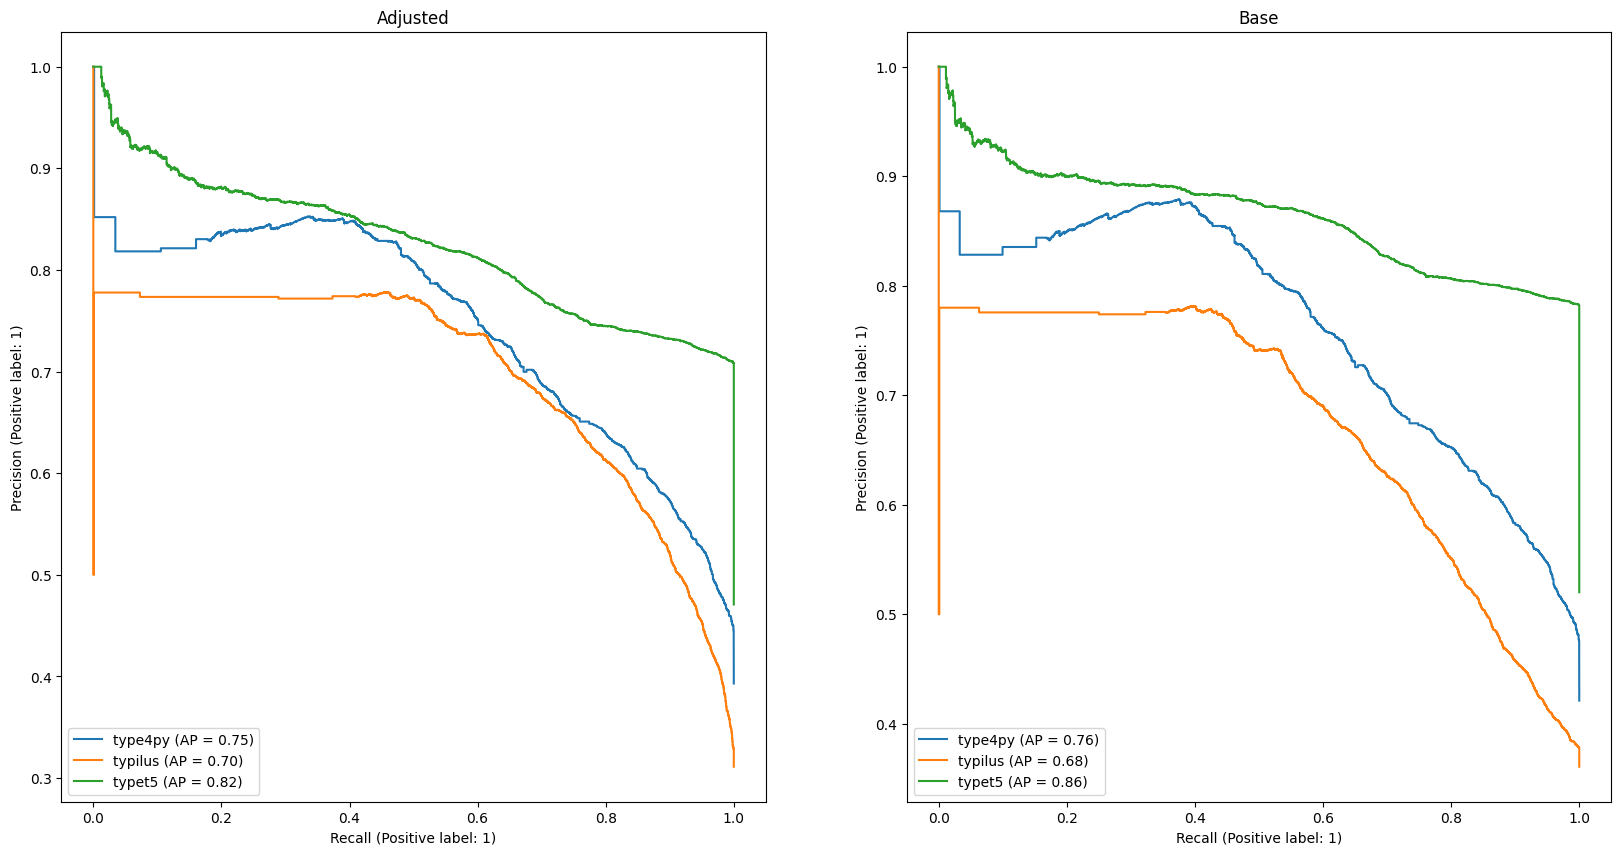

In [356]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize, LabelEncoder

precision_recall_fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for model in ("type4py", "typilus", "typet5"):
    for perf_eval, ax in zip([adjusted_eval, base_eval], [ax1, ax2]):        
        PrecisionRecallDisplay.from_predictions(
            y_true=perf_eval[f"anno_{model}"] == perf_eval["gt_anno"],
            y_pred=perf_eval[f"probability_{model}"],
            name=model,
            ax=ax,
        )

ax1.set_title("Adjusted")
ax2.set_title("Base")

In [354]:
%%capture

import numpy as np

configs = []

agents = ["type4py", "typilus", "typet5"]
# agent_thresholds = dict(zip(agents, [
def baheer_experiment():
    for agent1_tag, agent2_tag, agent3_tag in itertools.permutations(agents, r=3):
        for agent1_threshold, agent2_threshold in itertools.combinations_with_replacement(np.linspace(0, 1, 21).tolist(), r=2):
            adjusted_basheer = baheer_frontend(adjusted_eval, agent1_tag, agent1_threshold, agent2_tag, agent2_threshold, agent3_tag).rename(columns={"pred": "anno"})
            assert len(adjusted_basheer) == len(adjusted_eval)    
        
            #print(f"{agent1_tag=}, {agent1_threshold=}, {agent2_tag=}, {agent2_threshold=}, {agent3_tag=}")
            perf = pd.merge(
                left=adjusted_basheer, right=adjusted_eval, on=["repository", "file", "category", "qname", "qname_ssa"]
            )
            # display(perf[["repository", "file", "qname_ssa", "gt_anno", "anno", "strategy"] + [f"anno_{agent}" for agent in agents]])
            #print(perf["strategy"].value_counts(normalize=True))
            #print(perf["agent"].value_counts(normalize=True))
    
            p = experiments.predictions.performance(perf)
            configs.append((agent1_tag, agent2_tag, agent3_tag, agent1_threshold, agent2_threshold, p))
        
            print("\n\n")

In [355]:
if False:
    # configs.append((agent1_tag, agent2_tag, agent3_tag), (agent1_threshold, agent2_threshold), p)
    config_df = pd.DataFrame(configs, columns=["agent1", "agent2", "agent3", "agent1_threshold", "agent2_threshold", "performance"])
    display(config_df.sort_values(by=["performance"], ascending=False))